In [ ]:
!git clone https://github.com/RebekkalPangras/BioXtronomy-Demo.git

In [ ]:
!python /content/BioXtronomy-Demo/train_autoencoder.py --model /content/BioXtronomy-Demo/output/autoencoder.h5 --vis /content/BioXtronomy-Demo/output/recon_vis.png --plot /content/BioXtronomy-Demo/output/plot.png

In [ ]:
!python /content/BioXtronomy-Demo/index_images.py --model /content/BioXtronomy-Demo/output/autoencoder.h5 --index /content/BioXtronomy-Demo/output/index.pickle

In [ ]:
!python /content/BioXtronomy-Demo/search.py --model /content/BioXtronomy-Demo/output/autoencoder.h5 --index /content/BioXtronomy-Demo/output/index.pickle

In [6]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from imutils import build_montages
import numpy as np
import argparse
import pickle
import cv2
%matplotlib inline

def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)

def perform_search(queryFeatures, index, maxResults=64):
	# initialize our list of results
	results = []

	# loop over our index
	for i in range(0, len(index["features"])):
		# compute the euclidean distance between our query features
		# and the features for the current image in our index, then
		# update our results list with a 2-tuple consisting of the
		# computed distance and the index of the image
		d = euclidean(queryFeatures, index["features"][i])
		results.append((d, i))

	# sort the results and grab the top ones
	results = sorted(results)[:maxResults]

	# return the list of results
	return results

[INFO] loading MNIST dataset...
[INFO] loading autoencoder and index...
[INFO] encoding testing images...


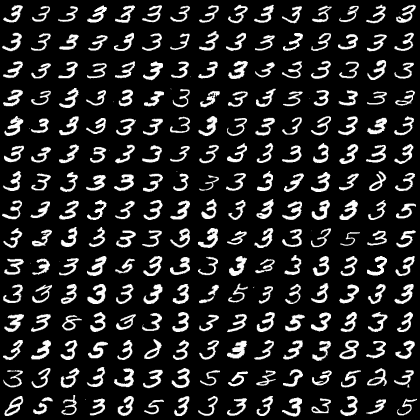

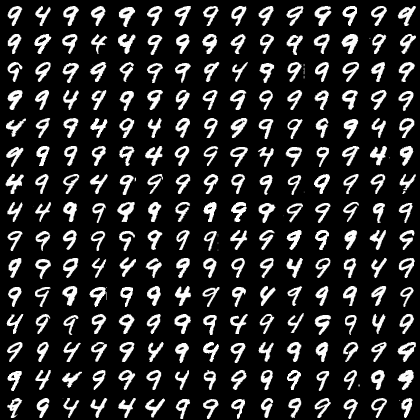

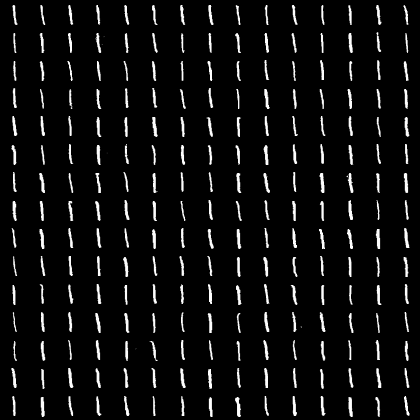

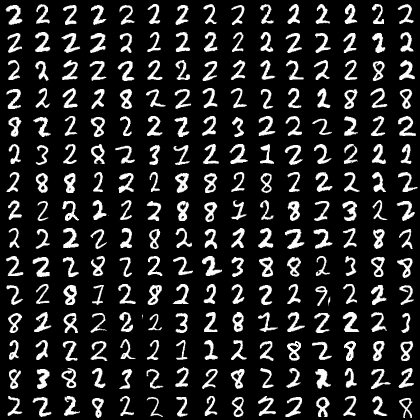

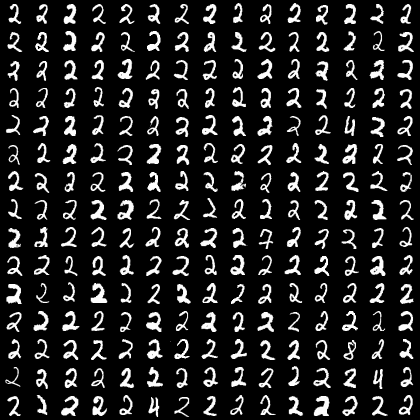

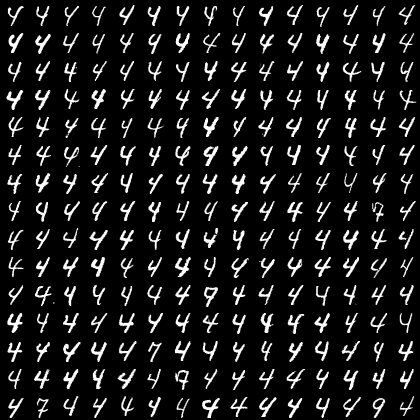

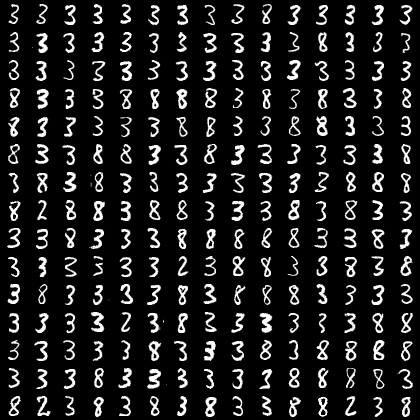

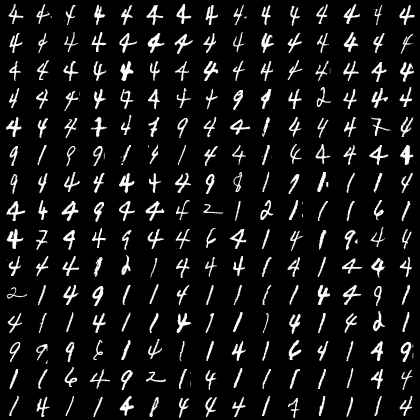

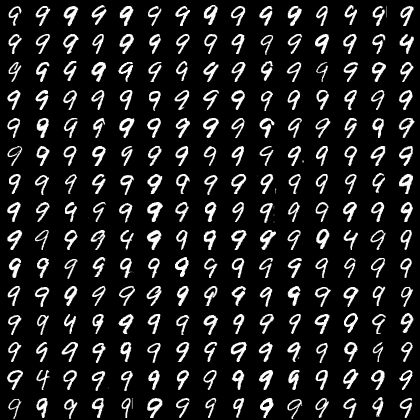

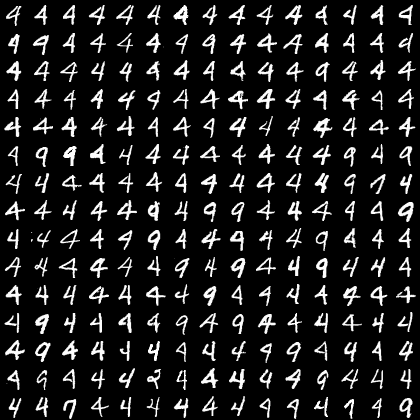

In [16]:
from google.colab.patches import cv2_imshow

model = "/content/BioXtronomy-Demo/output/autoencoder.h5"
index = "/content/BioXtronomy-Demo/output/index.pickle"
sample = 10

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# load the autoencoder model and index from disk
print("[INFO] loading autoencoder and index...")
autoencoder = load_model(model)
index = pickle.loads(open(index, "rb").read())

# create the encoder model which consists of *just* the encoder
# portion of the autoencoder
encoder = Model(inputs=autoencoder.input, 
                outputs=autoencoder.get_layer("encoded").output)

# quantify the contents of our input testing images using the encoder
print("[INFO] encoding testing images...")
features = encoder.predict(testX)

# randomly sample a set of testing query image indexes
queryIdxs = list(range(0, testX.shape[0]))
queryIdxs = np.random.choice(queryIdxs, size=sample,
	replace=False)

# loop over the testing indexes
for i in queryIdxs:
    # take the features for the current image, find all similar
    # images in our dataset, and then initialize our list of result
    # images
    queryFeatures = features[i]
    results = perform_search(queryFeatures, index, maxResults=225)
    images = []

    # loop over the results
    for (d, j) in results:
        # grab the result image, convert it back to the range
        # [0, 255], and then update the images list
        image = (trainX[j] * 255).astype("uint8")
        image = np.dstack([image] * 3)
        images.append(image)

    # display the query image
    query = (testX[i] * 255).astype("uint8")
    # img = cv2.imread("Query", query)
    cv2_imshow(query)
    
    # build a montage from the results and display it
    montage = build_montages(images, (28, 28), (15, 15))[0]
    # imgs = cv2.imread("Results", montage)
    cv2_imshow(montage)
    cv2.waitKey(0)